# **Bibliotecas**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import base

import joblib
import warnings
import IPython

from pathlib import Path

plt.style.use('seaborn')


IPython.display.clear_output(wait=True)

In [41]:
### Dicionário 3 - sales of all products, aggregated for each store
dict_3_eva = {} # número de vendas diárias de todos produtos, agregado por cada loja (dia 1 até dia 1941)

stores = list(np.unique(sales_train_eva['store_id'].values))

a = []
for i in range(1941):
    a.append('d_' +str(i+1))
    

for store in stores:
    
    b = np.concatenate((np.array(sales_train_eva[(sales_train_eva['store_id'] == store)].groupby(['store_id'])[a].sum()), np.array([np.nan]*28)),
    axis = None)[0:1941]
    
    dict_3_eva[str(store)] = pd.Series(b, index = calendar['date'][0:1941])

# **Importação dos dados**

In [11]:
# lendo os dados
INPUT_DIR = 'C:/Users/Igor/Desktop/PIBIC 2021 e 2022/Dados'

calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sales_train_val = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv') #sales_train d_1 até d_1913
sales_train_eva = pd.read_csv(f'{INPUT_DIR}/sales_train_evaluation.csv') #sales_train d_1 até d_1941

# NOTE: o banco sales_train_eva contempla o sales_train_val e ainda adciona observações das vendas dos dias d_1914 - d_1941

# **Análise exploratória dos dados**

In [12]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [5]:
selling_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [13]:
sample_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
sales_train_val

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [8]:
sales_train_eva

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


Vamos tentar identificar o tamanho do ciclo sazonal das séries a partir de uma visão geral do nível mais agregado para as vendas

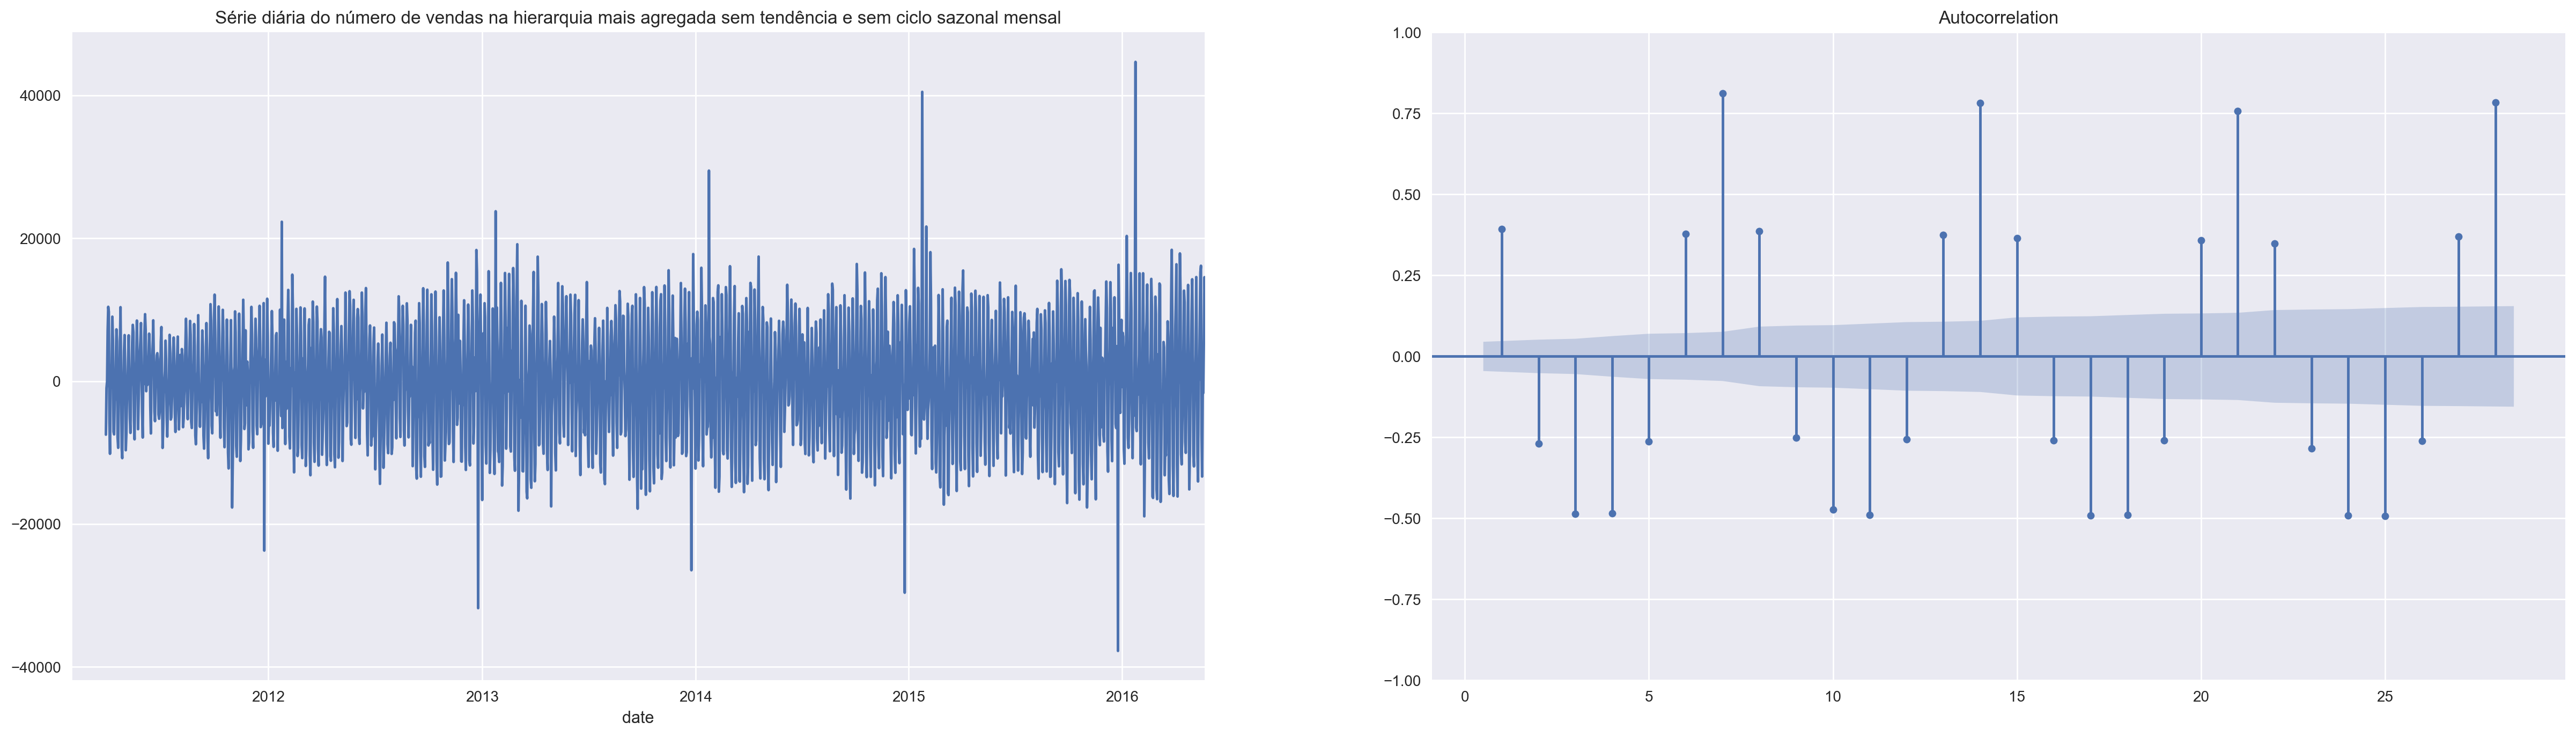

In [51]:
# Verificar o tamanho do ciclo sazonal -> ciclo sazonal semanal

a = base.dict_1_eva['all'] - base.dict_1_eva['all'].rolling(30).mean()

a = a.diff(30)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(30,8), dpi = 200)

a.plot(grid=True, ax = ax1, title = 'Série diária do número de vendas na hierarquia mais agregada sem tendência e sem ciclo sazonal mensal')



# Plot ACF
plot_acf(a.dropna(), ax=ax2, lags=28, zero=False)

plt.savefig("C:/Users/Igor/Desktop/PIBIC 2021 e 2022/ciclo_saz_sem.pdf", format="pdf", bbox_inches="tight")
plt.show()




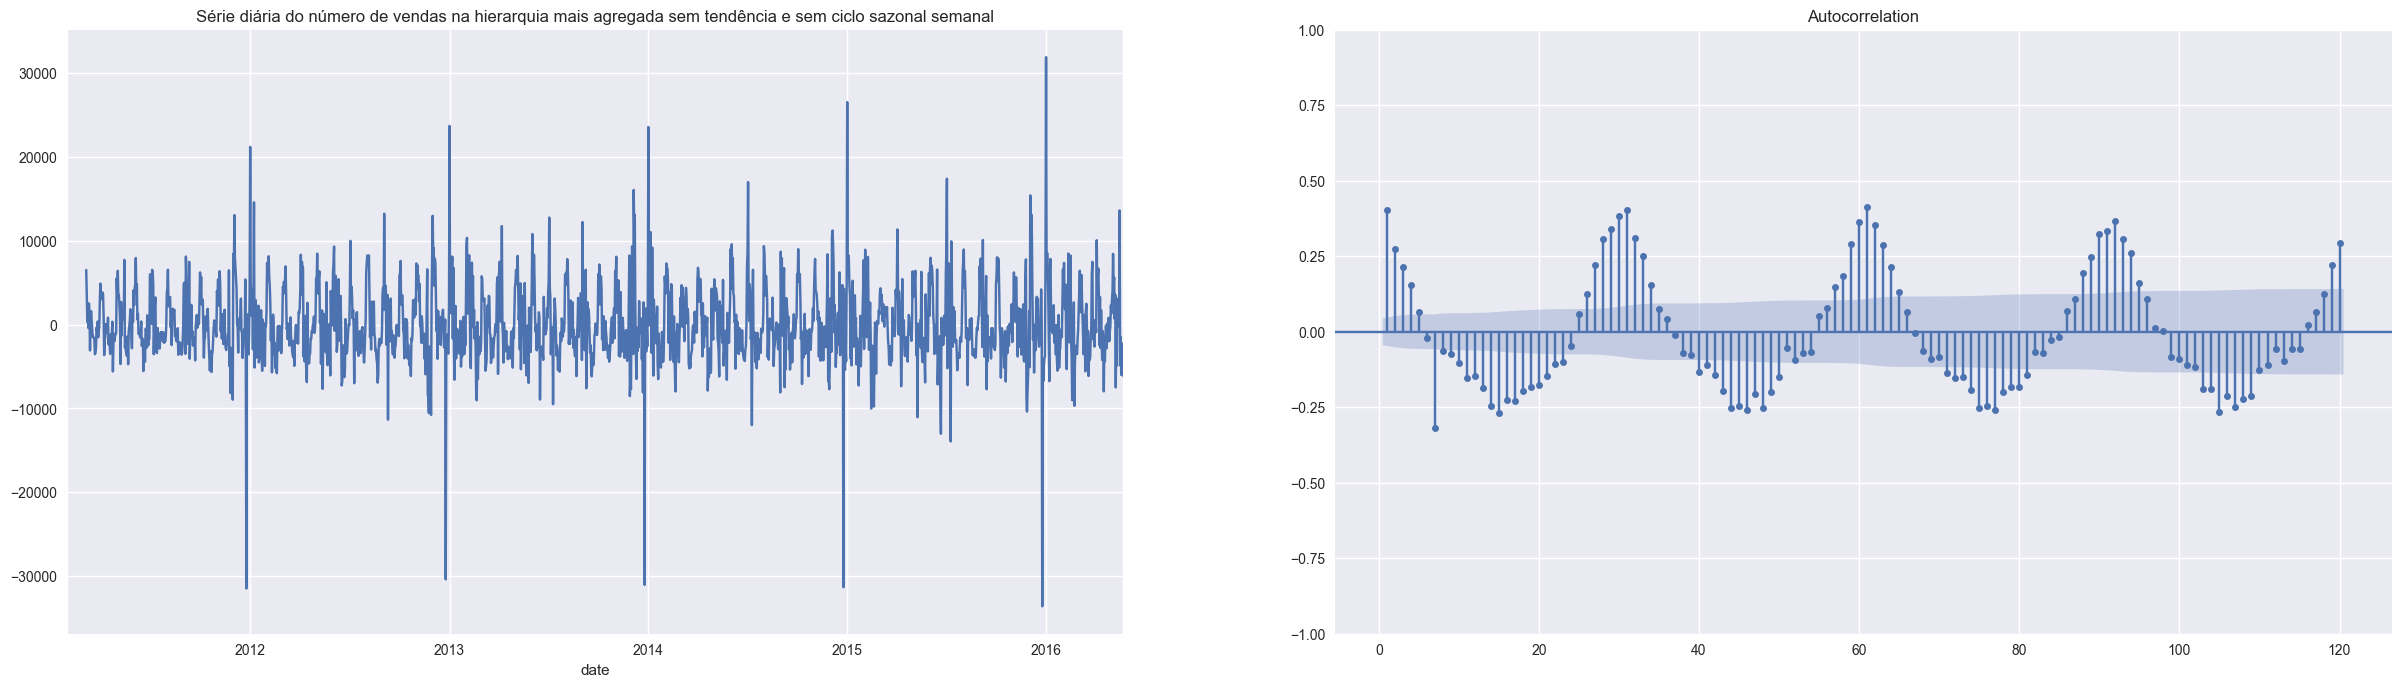

In [50]:
# Verificar o tamanho do ciclo sazonal -> ciclo sazonal mensal

a = base.dict_1_eva['all'] - base.dict_1_eva['all'].rolling(30).mean()

a = a.diff(7)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(30,8), dpi = 100)

a.plot(grid=True, ax = ax1, title = 'Série diária do número de vendas na hierarquia mais agregada sem tendência e sem ciclo sazonal semanal')


# Plot ACF
plot_acf(a.dropna(), ax=ax2, lags=120, zero=False)
plt.savefig("C:/Users/Igor/Desktop/PIBIC 2021 e 2022/ciclo_saz_men.pdf", format="pdf", bbox_inches="tight")
plt.show()

Tudo indica que as séries possuem mais de 1 ciclo sazonal, ou ao menos:

* Ciclo sazonal semanal
* Ciclo sazonal mensal
* Um possível ciclo sazonal anual

In [160]:
warnings.filterwarnings("ignore")

base.attach_datas_val(base.dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2').head(3)

,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI,#sales,...,event_type_1_Sporting,event_type_1_nan,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_name_2_nan,event_type_2_Cultural,event_type_2_Religious,event_type_2_nan
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,148.0,...,0,1,0,0,0,0,1,0,0,1
2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0,151.0,...,0,1,0,0,0,0,1,0,0,1
2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0,66.0,...,0,1,0,0,0,0,1,0,0,1


In [12]:
base.attach_datas_val(base.dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2').columns

Index(['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'snap_CA',
       'snap_TX', 'snap_WI', '#sales', 'media_preco_de_venda', 'filtro',
       'event_name_1_Chanukah End', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', 'event_name_1_Father's day',
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', 'event_name_1_Mother's day',
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach End',
       'event_name_1_PresidentsDay', 'event_name_1_Purim End',
       'event_name_1_Ramadan starts', 'event_name_1_StPatricksDay',
       'event_name_1_Supe

#  **AJUSTE DOS 70 MODELOS SARIMAX PARA VALIDATION**

ajuste e previsões pedidas no sample submission pela M5

In [28]:
# para rodar: 2h para ajustar e salvar os modelos; 25min para abrir (carregar) os modelos já ajustados
warnings.filterwarnings("ignore")

for i in (base.dict_9_val.keys()):

    b = base.attach_datas_val(base.dict_9_val[i], i[0:4], i[5:])

    e1 = base.attach_datas_val(base.dict_9_val[i], i[0:4], i[5:])[['wday', 'media_preco_de_venda', 'snap_'+str(i[0:2])]][0:1941]
    a =  1 - (np.array(base.attach_datas_val(base.dict_9_val[i], i[0:4], i[5:])['event_name_1_nan'])*
    np.array(base.attach_datas_val(base.dict_9_val[i], i[0:4], i[5:])['event_name_2_nan']))
    a = pd.Series(a, index = base.attach_datas_val(base.dict_9_val[i], i[0:4], i[5:]).index)
    e1['evento'] = a[0:1941]
        
    #result = pm.auto_arima(
    #    b['#sales'][0:1913], d = 1, start_p=0, start_q=0, max_p=3, max_q=3,
    #    seasonal = True, m = 7, D=1, start_P=0, start_Q=0, max_P=1, max_Q=1,
    #    information_criterion='aic', error_action='ignore', stepwise=True,
    #    X = e1[0:1913]
    #    )


    INPUT_PATH = 'C:/Users/Igor/Desktop/PIBIC 2021 e 2022/Modelos_validation'

    filepath = f'{INPUT_PATH}/great_model_' + str(i) + str('.pkl')

    #joblib.dump(result, filepath)

    result = joblib.load(filepath)

    forecast = result.predict(28, X= e1[1913:1941])
    

    if str('FOODS') in str(i):

        z1 = []
        for j1 in sample_submission['id']:
            if (str(j1).find(str(b['filtro'][0][0:7])) != -1) & (str(j1).find(str(b['filtro'][0][8:])) != -1):
                z1.append(j1)

        for k1 in z1:

            ind = sample_submission[sample_submission['id']==k1].index[0]
            
            #forecast = result.predict(28, X= e1[1913:1941])
            sample_submission.loc[ind:ind,'F1':'F28'] = np.round((base.dict_12_val[k1][-28:].sum()/base.dict_9_val[i][-28:].sum())*forecast, 0)
    
    elif str('HOBBIES') in str(i):

        z2 = []
        for j2 in sample_submission['id']:
            if (str(j2).find(str(b['filtro'][0][0:9])) != -1) & (str(j2).find(str(b['filtro'][0][10:])) != -1):
                z2.append(j2)

        for k2 in z2:

            ind = sample_submission[sample_submission['id']==k2].index[0]
            
            #forecast = result.predict(28, X= e1[1913:1941])
            sample_submission.loc[ind:ind,'F1':'F28'] = np.round((base.dict_12_val[k2][-28:].sum()/base.dict_9_val[i][-28:].sum())*forecast, 0)

    elif str('HOUSEHOLD') in str(i):

        z3 = []
        for j3 in sample_submission['id']:
            if (str(j3).find(str(b['filtro'][0][0:11])) != -1) & (str(j3).find(str(b['filtro'][0][12:])) != -1):
                z3.append(j3)

        for k3 in z3:
            
            ind = sample_submission[sample_submission['id']==k3].index[0]


            #forecast = result.predict(28, X= e1[1913:1941])
            sample_submission.loc[ind:ind,'F1':'F28'] = np.round((base.dict_12_val[k3][-28:].sum()/base.dict_9_val[i][-28:].sum())*forecast, 0)   

In [29]:
sample_submission.head(10)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1,1,1,1,1,1,1,1,1,...,1,2,1,1,1,1,1,1,2,2
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,HOBBIES_1_004_CA_1_validation,2,2,1,2,2,2,2,2,2,...,2,3,3,3,2,2,2,2,3,3
4,HOBBIES_1_005_CA_1_validation,2,1,1,1,1,2,2,2,1,...,2,2,2,2,2,1,2,2,2,2
5,HOBBIES_1_006_CA_1_validation,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,HOBBIES_1_007_CA_1_validation,0,0,0,0,0,1,1,1,0,...,0,1,1,1,0,0,0,0,1,1
7,HOBBIES_1_008_CA_1_validation,10,8,7,8,8,11,11,11,9,...,9,13,12,12,10,8,9,10,13,13
8,HOBBIES_1_009_CA_1_validation,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9,HOBBIES_1_010_CA_1_validation,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [308]:
#sales_train_eva[sales_train_eva['id']=='HOBBIES_1_001_CA_1_evaluation'].iloc[:, -28:-1].values


In [309]:
#b = base.attach_datas_val(base.dict_9_val['CA_1_HOBBIES_1'], 'CA_1', 'HOBBIES_1')

#e1 = base.attach_datas_val(base.dict_9_val['CA_1_HOBBIES_1'], 'CA_1', 'HOBBIES_1')[['wday', 'media_preco_de_venda', 'snap_WI']][0:1941]
#a =  1 - (np.array(base.attach_datas_val(base.dict_9_val['CA_1_HOBBIES_1'], 'CA_1', 'HOBBIES_1')['event_name_1_nan'])*
#np.array(base.attach_datas_val(base.dict_9_val['CA_1_HOBBIES_1'], 'CA_1', 'HOBBIES_1')['event_name_2_nan']))
#a = pd.Series(a, index = base.attach_datas_val(base.dict_9_val['CA_1_HOBBIES_1'], 'CA_1', 'HOBBIES_1').index)
#e1['evento'] = a[0:1941]

#result = pm.auto_arima(
#    b['#sales'][0:1913], d = 1, start_p=0, start_q=0, max_p=3, max_q=3,
#    seasonal = True, m = 7, D=1, start_P=0, start_Q=0, max_P=1, max_Q=1,
#    information_criterion='aic', error_action='ignore', stepwise=True,
#    X = e1[0:1913]
#)

#aa = result.predict(28, X= e1[1913:1941])

In [310]:
#np.round((base.dict_12_val['HOBBIES_1_009_CA_1_validation'].sum()/base.dict_9_val['CA_1_HOBBIES_1'].sum())*aa, 0)

#  **AJUSTE DOS 70 MODELOS SARIMAX PARA EVALUATION**

ajuste e previsões pedidas no sample submission pela M5

In [30]:
# para rodar: 2h para ajustar e salvar os modelos; 25min para abrir (carregar) os modelos já ajustados
warnings.filterwarnings("ignore")

for i in (base.dict_9_eva.keys()):

    b = base.attach_datas_eva(base.dict_9_eva[i], i[0:4], i[5:])

    e1 = base.attach_datas_eva(base.dict_9_eva[i], i[0:4], i[5:])[['wday', 'media_preco_de_venda', 'snap_'+str(i[0:2])]][0:1969]
    a =  1 - (np.array(base.attach_datas_eva(base.dict_9_eva[i], i[0:4], i[5:])['event_name_1_nan'])*
    np.array(base.attach_datas_eva(base.dict_9_eva[i], i[0:4], i[5:])['event_name_2_nan']))
    a = pd.Series(a, index = base.attach_datas_eva(base.dict_9_eva[i], i[0:4], i[5:]).index)
    e1['evento'] = a[0:1969]
        
    #result = pm.auto_arima(
    #    b['#sales'][0:1941], d = 1, start_p=0, start_q=0, max_p=3, max_q=3,
    #    seasonal = True, m = 7, D=1, start_P=0, start_Q=0, max_P=1, max_Q=1,
    #    information_criterion='aic', error_action='ignore', stepwise=True,
    #    X = e1[0:1941]
    #    )


    INPUT_PATH = 'C:/Users/Igor/Desktop/PIBIC 2021 e 2022/Modelos_evaluation'

    filepath = f'{INPUT_PATH}/great_model_' + str(i) + str('.pkl')

    #joblib.dump(result, filepath)

    result = joblib.load(filepath)

    forecast = result.predict(28, X= e1[1941:1969])
    

    if str('FOODS') in str(i):

        z1 = []
        for j1 in sample_submission['id']:
            if (str(j1).find(str(b['filtro'][0][0:7])) != -1) & (str(j1).find(str(b['filtro'][0][8:])) != -1):
                z1.append(j1)

        for k1 in z1:

            ind = sample_submission[sample_submission['id']==k1].index[0]
            
            #forecast = result.predict(28, X= e1[1913:1941])
            sample_submission.loc[ind:ind,'F1':'F28'] = np.round((base.dict_12_eva[k1][-28:].sum()/base.dict_9_eva[i][-28:].sum())*forecast, 0)
    
    elif str('HOBBIES') in str(i):

        z2 = []
        for j2 in sample_submission['id']:
            if (str(j2).find(str(b['filtro'][0][0:9])) != -1) & (str(j2).find(str(b['filtro'][0][10:])) != -1):
                z2.append(j2)

        for k2 in z2:

            ind = sample_submission[sample_submission['id']==k2].index[0]
            
            #forecast = result.predict(28, X= e1[1913:1941])
            sample_submission.loc[ind:ind,'F1':'F28'] = np.round((base.dict_12_eva[k2][-28:].sum()/base.dict_9_eva[i][-28:].sum())*forecast, 0)

    elif str('HOUSEHOLD') in str(i):

        z3 = []
        for j3 in sample_submission['id']:
            if (str(j3).find(str(b['filtro'][0][0:11])) != -1) & (str(j3).find(str(b['filtro'][0][12:])) != -1):
                z3.append(j3)

        for k3 in z3:
            
            ind = sample_submission[sample_submission['id']==k3].index[0]


            #forecast = result.predict(28, X= e1[1913:1941])
            sample_submission.loc[ind:ind,'F1':'F28'] = np.round((base.dict_12_eva[k3][-28:].sum()/base.dict_9_eva[i][-28:].sum())*forecast, 0)

In [32]:
sample_submission.tail(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60970,FOODS_3_818_WI_3_evaluation,2,2,2,2,2,2,2,2,2,...,2,3,3,2,2,2,2,2,2,2
60971,FOODS_3_819_WI_3_evaluation,2,2,2,2,2,2,2,2,2,...,2,3,3,2,2,2,2,2,2,2
60972,FOODS_3_820_WI_3_evaluation,1,1,1,1,2,2,2,1,1,...,2,2,2,1,2,2,1,2,2,2
60973,FOODS_3_821_WI_3_evaluation,1,1,1,1,1,1,1,1,1,...,1,2,1,1,1,1,1,1,1,1
60974,FOODS_3_822_WI_3_evaluation,2,2,2,2,2,3,2,2,2,...,2,3,3,2,2,2,2,2,3,2
60975,FOODS_3_823_WI_3_evaluation,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
60978,FOODS_3_826_WI_3_evaluation,1,1,1,1,1,2,2,1,1,...,1,2,2,1,1,1,1,1,2,2
60979,FOODS_3_827_WI_3_evaluation,1,1,1,1,1,2,1,1,1,...,1,2,2,1,1,1,1,1,2,1


In [339]:
#sample_submission[sample_submission['id']=='FOODS_3_822_WI_3_evaluation'].values

array([['FOODS_3_822_WI_3_evaluation', 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4,
        4, 4, 5, 4, 3, 4, 4, 3, 5, 5, 3, 4, 4, 3, 3, 4, 4]], dtype=object)

In [328]:
#b = base.attach_datas_eva(base.dict_9_eva['WI_3_FOODS_3'], 'WI_3', 'FOODS_3')

#e1 = base.attach_datas_eva(base.dict_9_eva[i], i[0:4], i[5:])[['wday', 'media_preco_de_venda', 'snap_'+str(i[0:2])]][0:1969]
#a =  1 - (np.array(base.attach_datas_eva(base.dict_9_eva[i], i[0:4], i[5:])['event_name_1_nan'])*
#np.array(base.attach_datas_eva(base.dict_9_eva[i], i[0:4], i[5:])['event_name_2_nan']))
#a = pd.Series(a, index = base.attach_datas_eva(base.dict_9_eva[i], i[0:4], i[5:]).index)
#e1['evento'] = a[0:1969]
        
#result = pm.auto_arima(
#    b['#sales'][0:1941], d = 1, start_p=0, start_q=0, max_p=3, max_q=3,
#    seasonal = True, m = 7, D=1, start_P=0, start_Q=0, max_P=1, max_Q=1,
#    information_criterion='aic', error_action='ignore', stepwise=True,
#    X = e1[0:1941]
#   )

#aa = result.predict(28, X= e1[1913:1941])

In [336]:
#np.round((base.dict_12_eva['FOODS_3_824_WI_3_evaluation'].sum()/base.dict_9_eva['WI_3_FOODS_3'].sum())*aa, 0)

### SALVANDO O ARQUIVO PARA A SUBMISSÃO NA PÁGINA DA COMPETIÇÃO NO KAGGLE

In [33]:
filepath = Path('C:/Users/Igor/Desktop/PIBIC 2021 e 2022/sarimax28_submission.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
sample_submission.to_csv(filepath, index = False)


Public score usando a informação dos últimos 28 dias para desagregar a previsões:  1.10555

Private score usando a informação dos últimos 28 dias para desagregar as previsões: 1.08201 (Score para classifcação na competição)

>Corte mínimo aceitável: 0.75238 no contexto do leaderboard da M5

>O resultado foi **RUIM** no contexto do leaderboard da M5

>Posição na M5: número 2406

>Total de participantes número 5558

#  **AJUSTE DOS 70 MODELOS Dynamic Harmonic Regression PARA VALIDATION**

#  **AJUSTE DOS 70 MODELOS Dynamic Harmonic Regression PARA EVALUATION**